<a href="https://colab.research.google.com/github/Cristinamulas/transfer_learning_keras/blob/main/model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16,ResNet50

'Import the datagenerator to augment images'
from keras.preprocessing.image import ImageDataGenerator

'''Import the optimizers and leanring rate annealer (which will reduce the learning rate once a particular metric we choose(in this case validation error) 
does not reduce after a user defined number of epochs)'''
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau

'Lastly import the final layers that will be added on top of the base model'
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.models import Sequential

import datetime
import keras

In [ ]:
def plot_images_from_dir(path):
    """ it takes a path and return the plot fo each image"""
    images_classes = []
    for cls in os.listdir(path): # get all the classes in for each folder
         if cls != '.DS_Store':
            images_classes.append(cls)
    for i in images_classes: # loop over each class
        new_images = []
        my_folder = os.path.join(path,i)
        for file in os.listdir(os.path.join(path,i)):
            if file != '.DS_Store' and file != '.ipynb_checkpoints':
                new_images.append(cv2.imread(os.path.join(my_folder,file))) # convert the path into an array
        plt.figure(figsize=(50,50))
        columns = 10
        for i, image in enumerate(new_images):
            plt.subplot(len(new_images) / columns + 1, columns, i + 1)
            plt.imshow(image)
            plt.show()

In [ ]:
# folder = "/Users/cristinamulas/Desktop/transfer_learning_keras/data/val"

# plot_images_from_dir(folder)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.getcwd()
os.chdir('/content/drive/My Drive/transfer_learning_keras/data/')
os.getcwd()


'/content/drive/My Drive/transfer_learning_keras/data'

In [6]:
base_path = os.getcwd() # get the working direntory
train_data_path = os.path.join(base_path + '/train') # add the new folder
train_data_path

test_data_path = os.path.join(base_path + '/test') # add the new folder
test_data_path

val_data_path = os.path.join(base_path + '/val') # add the new folder
val_data_path

'/content/drive/My Drive/transfer_learning_keras/data/val'

In [7]:
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=4,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=True)
test_generator = ImageDataGenerator(rescale=1./255)

In [8]:
X_train_generator = train_generator.flow_from_directory(train_data_path, target_size=(32, 32), color_mode="rgb", batch_size = 32)
X_val_generator = test_generator.flow_from_directory(val_data_path, target_size=(32, 32), color_mode="rgb" )
X_test_generator = test_generator.flow_from_directory(test_data_path, target_size=(32, 32), color_mode="rgb",  batch_size =32)

Found 1356 images belonging to 3 classes.
Found 291 images belonging to 3 classes.
Found 39 images belonging to 3 classes.


NameError: ignored

### Import VGG16 as a base model

In [9]:
base_model_1 = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58892288/58889256 [==============================] - 0s 0us/step


In [10]:
base_model_1.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [13]:

def model_generator(model, layers=[]):
    model = model
    for layer in layers:
        model.add(layer)
    model.summary()
    return model

In [43]:
layers = base_model_1.layers + [Flatten(), Dense(128,activation=('relu'),input_dim=512),Dropout(.2), Dense(3, activation='softmax')]
# compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.00005), "metrics":['accuracy']}
modelVGG16 = model_generator(Sequential(), layers)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

In [46]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [47]:
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":adam, "metrics":['accuracy']}


In [48]:
  def fit(model,  compile_kwargs={}):
        model.compile(**compile_kwargs)
        log_dir = log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

        tbCallBack = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
        return model.fit(X_train_generator, epochs=15,  validation_data=X_val_generator,callbacks=[tbCallBack])
        

In [49]:
history = fit(modelc3, compile_kwargs)

Epoch 1/15
43/43 [==============================] - 6s 142ms/step - loss: 0.9136 - accuracy: 0.5354 - val_loss: 1.4484 - val_accuracy: 0.3230
Epoch 2/15
43/43 [==============================] - 6s 133ms/step - loss: 0.8617 - accuracy: 0.6077 - val_loss: 1.7379 - val_accuracy: 0.3058
Epoch 3/15
43/43 [==============================] - 6s 134ms/step - loss: 0.8302 - accuracy: 0.6291 - val_loss: 1.3434 - val_accuracy: 0.3299
Epoch 4/15
43/43 [==============================] - 6s 133ms/step - loss: 0.8137 - accuracy: 0.6423 - val_loss: 1.6631 - val_accuracy: 0.3058
Epoch 5/15
43/43 [==============================] - 6s 139ms/step - loss: 0.7732 - accuracy: 0.6689 - val_loss: 1.5790 - val_accuracy: 0.2818
Epoch 6/15
43/43 [==============================] - 6s 142ms/step - loss: 0.7750 - accuracy: 0.6829 - val_loss: 1.3933 - val_accuracy: 0.3162
Epoch 7/15
43/43 [==============================] - 6s 134ms/step - loss: 0.7436 - accuracy: 0.6881 - val_loss: 1.3958 - val_accuracy: 0.3368
Epoch 

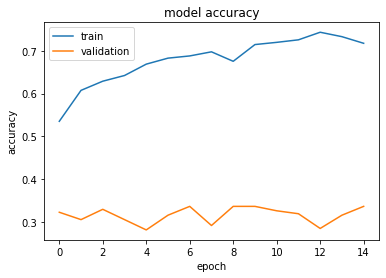

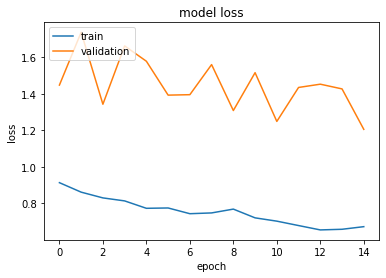

In [51]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [58]:
os.getcwd()
os.chdir('/content/drive/My Drive/transfer_learning_keras/data/val/plastic')

In [59]:
len(os.listdir())

25